<a href="https://colab.research.google.com/github/HaniaGhouse0407/Amazon-Product-Review--Sentiment-Analysis/blob/main/SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget "https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz"
! tar -xzf "/content/domain_sentiment_data.tar.gz"


--2023-07-20 17:27:17--  https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz
Resolving www.cs.jhu.edu (www.cs.jhu.edu)... 128.220.13.64
Connecting to www.cs.jhu.edu (www.cs.jhu.edu)|128.220.13.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30586147 (29M) [application/x-gzip]
Saving to: ‘domain_sentiment_data.tar.gz’

domain_sentiment_da 100%[===================>]  29.17M  20.4MB/s    in 1.4s    

2023-07-20 17:27:19 (20.4 MB/s) - ‘domain_sentiment_data.tar.gz’ saved [30586147/30586147]



In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
import re
from pickle import dump
from pickle import load

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import gensim
import gensim.downloader as api

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense, Embedding, TimeDistributed
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Data PreProcessing**


In [ ]:
from nltk.tokenize import word_tokenize
def clean_sentence(sentence: str) -> list:
  # Remove the review tag
  tags = re.compile("(|<\/review_text>)")
  sentence = re.sub(tags, '', sentence)

  # lower case
  sentence = sentence.lower()

  # Remove emails and urls
  email_urls = re.compile("(\bhttp.+? | \b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b)")
  sentence = re.sub(email_urls, '', sentence)

  # Some used '@' to hide offensive words (bla -> bl@)
  ats = re.compile('@')
  sentence = re.sub(ats, 'a', sentence)

  # Remove Punctuation
  # punc = re.compile("[!\"\#$\%\&\'\*\+,\-\.\/\:;<=>\?
  punc = re.compile("[^\w\s(\w+\-\w+)]")
  sentence = re.sub(punc, '', sentence)

  # Remove stopwords and tokenize
  # sentence = sentence.split(sep=' ')
  sentence = word_tokenize(sentence)
  sentence = [word for word in sentence if not word in stopwords.words()]

  # Stemming (Returning to root)
  # stemmer = PorterStemmer()
  # sentence = [stemmer.stem(word) for word in sentence]


  return sentence


**Data Splitting**

In [ ]:
path = "/content/sorted_data_acl/"
regex_review = re.compile(".+?<\/review_text>", flags=re.DOTALL)

# Training Data
folders = ["books","dvd","electronics"]
x_train = list()
y_train = list()
print('Reading Train Data')
for folder in folders:
  temp = open(path+folder+"/negative.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Negative reviews from",folder)
  for sentence in temp:
    x_train.append(clean_sentence(sentence))
    y_train.append(0)


  temp = open(path+folder+"/positive.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Positive reviews from",folder)
  for sentence in temp:
    x_train.append(clean_sentence(sentence))
    y_train.append(1)



# Test data
folders = ["kitchen_&_housewares"]
x_test = list()
y_test = list()
print('Reading Test Data')
for folder in folders:
  temp = open(path+folder+"/negative.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Negative reviews from",folder)
  for sentence in temp:
    x_test.append(clean_sentence(sentence))
    y_test.append(0)


  temp = open(path+folder+"/positive.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Positive reviews from",folder)
  for sentence in temp:
    x_test.append(clean_sentence(sentence))
    y_test.append(1)

Reading Train Data
Reading 1000 Negative reviews from books
Reading 1000 Positive reviews from books
Reading 1000 Negative reviews from dvd
Reading 1000 Positive reviews from dvd
Reading 1000 Negative reviews from electronics
Reading 1000 Positive reviews from electronics
Reading Test Data
Reading 1000 Negative reviews from kitchen_&_housewares
Reading 1000 Positive reviews from kitchen_&_housewares


**TASK 3 - MODEL BUILDING**



Vocab size: 82841
Len train: 6000
Len test: 2000
Train shape: (6000, 125)
Test shape: (2000, 125)
Train label shape: (6000,)
Test label shape: (2000,)
{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1, 'record_format': 'dict', 'file_size': 6344358, 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py', 'license': 'All files released for the task are free for general research use', 'fields': {'2016-train': ['...'], '2016-dev': ['...'], '2017-test': ['...'], '2016-test': ['...']}, 'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://git

Model: "SentimentAnalysis"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 125, 200)          16568200  
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 16,737,035
Trainable params: 168,835
Non-trainable params: 16,568,200
_________________________________________________________________
Epoch 1/10
150/150 [==============================] - 41s 262ms/step - loss: 0.7041 - accuracy: 0.5798 - val_loss: 0.7707 - val_accuracy: 0.1958
Epoch 2/10
150/150 [==============================] - 32s 211ms/step - loss: 0.6631 - accuracy: 0.6135 - val_loss: 0.8930 - val_accuracy: 0.1758
Epoch

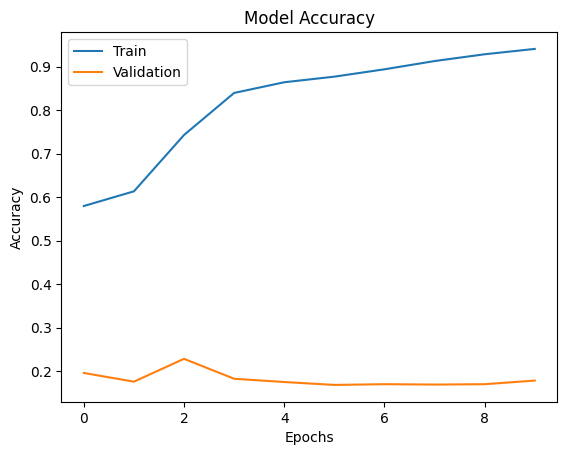

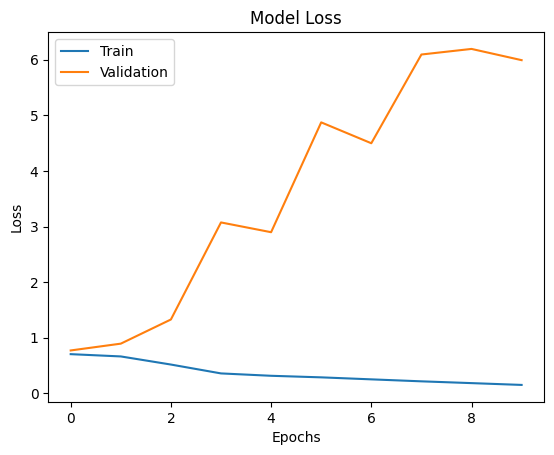

In [ ]:
temp_file = open('x_train', 'wb')
save_x_train = dump(x_train, temp_file)
temp_file.close()

temp_file = open('y_train', 'wb')
save_y_train = dump(y_train, temp_file)
temp_file.close()

temp_file = open('x_test', 'wb')
save_x_test = dump(x_test, temp_file)
temp_file.close()

temp_file = open('y_test', 'wb')
save_y_test = dump(y_test, temp_file)
temp_file.close()

vocab = set()
for sentence in x_train:
    for word in sentence:
        vocab.add(word)

vocab.add('')  # for dummy words, to avoid adding a word that has meaning
print("Vocab size:", len(vocab))

# Make a mapping between words and their IDs
word2id = {word: id for id, word in enumerate(vocab)}
id2word = {id: word for id, word in enumerate(vocab)}


def encode_sentence(old_sentence):
    encoded_sentence = []
    dummy = word2id['']
    for word in old_sentence:
        try:
            encoded_sentence.append(word2id[word])
        except KeyError:
            encoded_sentence.append(dummy)  # the none char
    return encoded_sentence


# Encoding train sentences
x_train_encoded = [encode_sentence(sentence) for sentence in x_train]

# Encoding test sentences
x_test_encoded = [encode_sentence(sentence) for sentence in x_test]

print("Len train:", len(x_train_encoded))
print("Len test:", len(x_test_encoded))

MAX_SEQ_LEN = 125
dummy = word2id['']

# Padding train sentences
x_train_padded = pad_sequences(x_train_encoded, maxlen=MAX_SEQ_LEN, dtype='int32', padding='post', truncating='post',
                               value=dummy)
print("Train shape:", x_train_padded.shape)

# Padding test sentences
x_test_padded = pad_sequences(x_test_encoded, maxlen=MAX_SEQ_LEN, dtype='int32', padding='post', truncating='post',
                              value=dummy)
print("Test shape:", x_test_padded.shape)

# Changing labels type and shape for training
y_train = np.array(y_train)
y_train = y_train.reshape((-1,))
print("Train label shape:", y_train.shape)

y_test = np.array(y_test)
y_test = y_test.reshape((-1,))
print("Test label shape:", y_test.shape)

# embedding_path = "/content/glove.6B.100d.txt"
# embeddings_index = {}

# with open(embedding_path, encoding="utf8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype="float32")
#         embeddings_index[word] = coefs

# embedding_dim = 100  # Size of the word embeddings
# num_words = len(word2id) + 1  # Add 1 for unknown words
# embedding_matrix = np.zeros((num_words, embedding_dim))

# for word, id in word2id.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[id] = embedding_vector
import gensim.downloader as api

# Check available models and their names
print(api.info())

# Load the GloVe model
w2v = api.load('glove-twitter-200')

# Use the loaded model for further processing
w2v.most_similar("mahmoud")

num_words = len(vocab)
embed_size, = w2v['mahmoud'].shape
embedding_matrix = np.zeros(shape=(num_words, embed_size))

for word, id in word2id.items():
  try:
    embedding_matrix[id] = w2v[word]
  except KeyError:
    embedding_matrix[id] = np.zeros(embed_size)

embedding_matrix.shape

tf.keras.backend.clear_session()

# Create model
lstm_model = Sequential(name='SentimentAnalysis')
lstm_model.add(Input(shape=(MAX_SEQ_LEN,), dtype='int32'))
lstm_model.add(Embedding(input_dim=num_words,
                         output_dim=embed_size,
                         input_length=MAX_SEQ_LEN,
                         weights=[embedding_matrix],
                         trainable=False))
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(units=3, activation='softmax'))

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
lstm_model.summary()




**Model Training and Evaluation**

In [ ]:
# Train the model
history = lstm_model.fit(x_train_padded,
                         y_train,
                         validation_split=0.2,
                         batch_size=32,
                         epochs=10)

# Evaluate the model
loss, accuracy = lstm_model.evaluate(x_test_padded, y_test)
print("Test accuracy:", round(accuracy * 100, 2), "%")

# Plot training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**PREDICTIONS**

In [ ]:
# Custom function to predict sentences
def lstm_predict(sentence:str):
  sentence = clean_sentence(sentence)
  # Encode sentence
  ready_sentence = encode_sentence(sentence)
  # Padding sentence
  ready_sentence = pad_sequences(sequences = [ready_sentence],
                                 maxlen=MAX_SEQ_LEN,
                                 dtype='int32',
                                 padding='post',
                                 truncating='post',
                                 value = dummy)

  # Predict
  prediction = round(lstm_model.predict(ready_sentence)[0][0])
  if prediction==0:
    print("Negative Review")
  elif prediction==1:
    print("Positive Review")
  else:
    print('Error')

In [ ]:
# Straight forward positive
lstm_predict("this sucks")


1/1 [==============================] - 1s 633ms/step
Positive Review


**EXPERIMENTAL ACCURATE MODEL**


In [ ]:
tf.keras.backend.clear_session() # Makes sure old model was deleted if exists

# create model
lstm_model = Sequential(name='sENTIMENT ANALYSIS 2 ')

lstm_model.add(Input(shape=(MAX_SEQ_LEN,), dtype='int32'))
lstm_model.add(Embedding(input_dim = len(vocab),            # Vocabulary Size (number of unique words for training)
                        output_dim = embed_size,            # Length of the vector for each word (embedding dimension)
                        input_length = MAX_SEQ_LEN,         # Maximum length of a sequence
                        weights = [embedding_matrix],       # Send the needed glove-twitter-200 Weights
                        trainable = False))

lstm_model.add(LSTM(units = 30,
                    return_sequences=True,
                    # dropout=0.5,
                    # recurrent_dropout=0.5
                    )
              )
lstm_model.add(LSTM(units = 30,
                    # return_sequences=True,
                    # dropout=0.5,
                    # recurrent_dropout=0.5
                    )
              )
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
lstm_model.summary()

Model: "Rating"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 125, 200)          16568200  
                                                                 
 lstm (LSTM)                 (None, 125, 30)           27720     
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 16,603,271
Trainable params: 35,071
Non-trainable params: 16,568,200
_________________________________________________________________


In [ ]:
train_data, train_labels = shuffle(x_train_padded, y_train, random_state=42)


In [ ]:

history=lstm_model.fit(train_data,
               train_labels,
               validation_split=0.20,
               batch_size = 50,
               epochs = 10)

Epoch 1/10
96/96 [==============================] - 15s 128ms/step - loss: 0.6779 - accuracy: 0.5648 - val_loss: 0.6712 - val_accuracy: 0.5950
Epoch 2/10
96/96 [==============================] - 12s 121ms/step - loss: 0.5849 - accuracy: 0.7121 - val_loss: 0.5753 - val_accuracy: 0.7133
Epoch 3/10
96/96 [==============================] - 12s 124ms/step - loss: 0.5453 - accuracy: 0.7423 - val_loss: 0.5477 - val_accuracy: 0.7358
Epoch 4/10
96/96 [==============================] - 12s 124ms/step - loss: 0.4846 - accuracy: 0.7850 - val_loss: 0.5000 - val_accuracy: 0.7742
Epoch 5/10
96/96 [==============================] - 12s 123ms/step - loss: 0.4306 - accuracy: 0.8138 - val_loss: 0.4866 - val_accuracy: 0.7725
Epoch 6/10
96/96 [==============================] - 12s 124ms/step - loss: 0.4100 - accuracy: 0.8271 - val_loss: 0.4463 - val_accuracy: 0.7867
Epoch 7/10
96/96 [==============================] - 13s 133ms/step - loss: 0.3875 - accuracy: 0.8440 - val_loss: 0.4618 - val_accuracy: 0.7950

In [ ]:
l, a = lstm_model.evaluate(x_test_padded, y_test)
print("Test accuracy:", round(a*100,2),"%")

63/63 [==============================] - 3s 32ms/step - loss: 0.4254 - accuracy: 0.8000
Test accuracy: 80.0 %


In [ ]:
# Custom function to predict sentences
def lstm_predict(sentence:str):
  sentence = clean_sentence(sentence)
  # Encode sentence
  ready_sentence = encode_sentence(sentence)
  # Padding sentence
  ready_sentence = pad_sequences(sequences = [ready_sentence],
                                 maxlen=MAX_SEQ_LEN,
                                 dtype='int32',
                                 padding='post',
                                 truncating='post',
                                 value = dummy)

  # Predict
  prediction = round(lstm_model.predict(ready_sentence)[0][0])
  if prediction==0:
    print("Negative Review")
  elif prediction==1:
    print("Positive Review")
  else:
    print('Error')

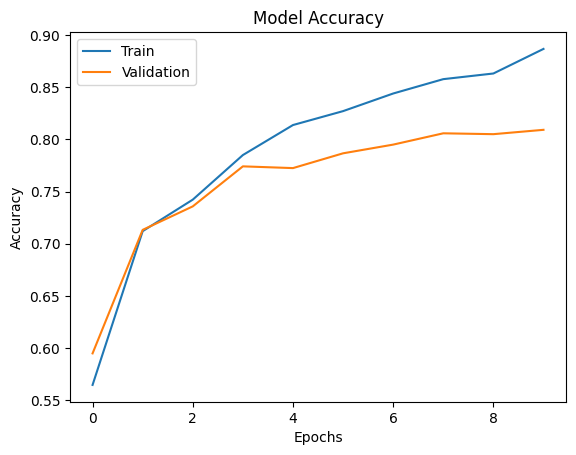

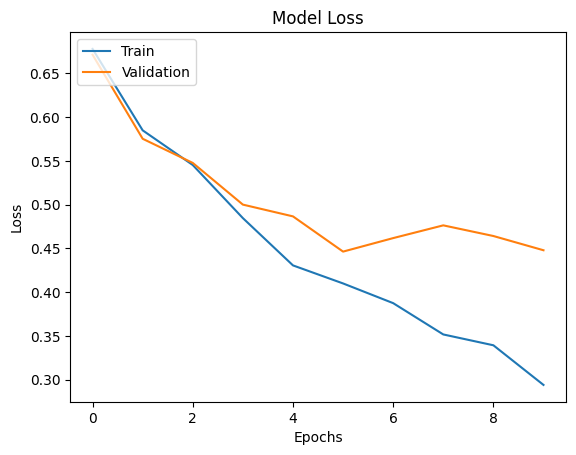

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Straight forward positive
lstm_predict("I really recommend this book")


1/1 [==============================] - 1s 806ms/step
Positive Review


In [ ]:

# Tricky positive
lstm_predict("The dvd included a big poster of my favorite hero. I just can't wait for the second episode")

1/1 [==============================] - 0s 41ms/step
Positive Review


In [ ]:
# Straight forward negative
lstm_predict("I don't know what the hell did i just read, the book is full nonsense")

1/1 [==============================] - 0s 39ms/step
Negative Review


In [ ]:
lstm_predict("this sucks")

1/1 [==============================] - 0s 57ms/step
Negative Review


In [ ]:
lstm_model.save('lstm_model.h5',save_format='h5')

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import numpy as np
import gensim.downloader as api
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from flask import Flask, request, render_template

app = Flask(__name__)
# Initialize GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the LSTM model
model = tf.keras.models.load_model('lstm_model.h5')

# Load the word embeddings model (GloVe)
w2v = api.load('glove-twitter-200')

# Function to clean and preprocess the input sentence
def clean_sentence(sentence):
    # Remove the review tag
    tags = re.compile("(|<\/review_text>)")
    sentence = re.sub(tags, '', sentence)

    # lower case
    sentence = sentence.lower()

    # Remove emails and urls
    email_urls = re.compile("(\bhttp.+? | \b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b)")
    sentence = re.sub(email_urls, '', sentence)

    # Some used '@' to hide offensive words (bla -> bl@)
    ats = re.compile('@')
    sentence = re.sub(ats, 'a', sentence)

    # Remove Punctuation
    # punc = re.compile("[!\"\#$\%\&\'\*\+,\-\.\/\:;<=>\?
    punc = re.compile("[^\w\s(\w+\-\w+)]")
    sentence = re.sub(punc, '', sentence)

    # Remove stopwords and tokenize
    # sentence = sentence.split(sep=' ')
    sentence = word_tokenize(sentence)
    sentence = [word for word in sentence if not word in stopwords.words()]

    # Stemming (Returning to root)
    # stemmer = PorterStemmer()
    # sentence = [stemmer.stem(word) for word in sentence]

    return sentence
from pickle import load
with open('x_train', 'rb') as file:
    x_train = load(file)

# Define word2id and old_sentence based on the provided code
vocab = set()
for sentence in x_train:
    for word in sentence:
        vocab.add(word)

# Add dummy word to vocab to avoid adding a word with meaning
vocab.add('')

# Make a mapping between words and their IDs
word2id = {word: id for id, word in enumerate(vocab)}
id2word = {id: word for id, word in enumerate(vocab)}

# Function to encode the sentence
def encode_sentence(sentence):
    encoded_sentence = []
    dummy = word2id['']
    for word in sentence:
        try:
            encoded_sentence.append(word2id[word])
        except KeyError:
            encoded_sentence.append(dummy)  # the none char
    return encoded_sentence

# Function to predict the sentiment
def lstm_predict(sentence):
    sentence = clean_sentence(sentence)
    ready_sentence = encode_sentence(sentence)

    # Padding sentence
    ready_sentence = pad_sequences(
        sequences=[ready_sentence],
        maxlen=125,
        dtype='int32',
        padding='post',
        truncating='post',
        value=0
    )

    # Predict
    prediction = round(model.predict(ready_sentence)[0][0])

    return "Positive Review" if prediction == 1 else "Negative Review"

# Flask route to handle the home page
@app.route('/')
def home():
    return render_template('index.html')

# Flask route to handle the form submission and display the prediction
@app.route('/', methods=['POST'])
def predict():
    sentence = request.form['sentence']
    prediction = lstm_predict(sentence)
    return render_template('index.html', prediction=prediction)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
